# Agente de No-Limit Texas Hold'em Poker

**Integrantes**: Jesus Serpa, Sebastian Yepes, Carlos Bejarano

## Resumen

Se implementa un agente de Aprendizaje por Refuerzo Profundo (Deep Reinforcement Learning) utilizando el algoritmo DQN (Deep Q-Network) para aprender a jugar al No-Limit Texas Hold'em Poker.

Utiliza la librería especializada `rlcard` para simular el entorno del juego y `PyTorch` para construir y entrenar las redes neuronales. El flujo de trabajo abarca desde la configuración del entorno, la definición de la arquitectura de la red y la memoria de experiencia, hasta el bucle de entrenamiento donde el agente juega contra oponentes aleatorios y finalmente evalúa su desempeño mediante tasa de victorias (Win Rate).

**Tecnnologías principales:** Python, PyTorch, RLCard, NumPy, Matplotlib.

## Dependencias y Entorno

Para la realización del proyecto se utilizaron las siguientes librerías:

* **rlcard:** Simulador de juegos de cartas para RL.

* **torch (PyTorch):** Framework de Deep Learning.

* **numpy:** Manejo de arrays y operaciones matemáticas.

* **matplotlib:** Visualización de gráficas.

* **collections:** Para estructuras de datos como `deque` para nuestro caso.

* **random:** Generación de números aleatorios.

## Instalación de Dependencias

Instala la librería `rlcard`, esta es necesaria para crear el entorno de simulación de Póker.

In [ ]:
!pip install -qU rlcard

## Importaciones

Importa todas las herramientas necesarias. Se destaca la importación de `RandomAgent` que servirá de oponente y `set_seed` para reproducibilidad.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random
import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import set_seed

## Configuración de Semillas

Se establece una semilla global en todas las librerías estocásticas como `numpy`, `torch`, `random` y `rlcard`.

Esto garantiza que los resultados del entrenamiento sean idénticos cada vez que se ejecute el notebook, facilitando la depuración.

In [ ]:
SEED = 69
set_seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

## Configuración del dispositivo

GPU si está disponible, sino CPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Creación del Entorno

Se inicializa el entorno de juego `no-limit-holdem` usando `rlcard`. Este objeto gestionará las reglas, estados y recompensas del juego.

In [ ]:
env = rlcard.make('no-limit-holdem', config={'seed': SEED})

## Extracción de Dimensiones de Estado y Acción

Se obtiene el tamaño del vector de entrada (características del juego, como cartas propias y comunitarias) y el número de acciones posibles.

**Salida:**

* `Dimensión del estado: 54`, el agente recibe un vector e 54 números representando la mesa.

* `Número de acciones: 5` (Fold, Check/Call, Raise, etc).

In [ ]:
state_shape = env.state_shape[0]

In [ ]:
if isinstance(state_shape, list):
    state_shape = state_shape[0]
num_actions = env.num_actions # Número de acciones posibles

In [ ]:
print(f"Dimensión del estado: {state_shape}")
print(f"Número de acciones: {num_actions}")
print(f"Acciones disponibles: Fold (0), Check/Call (1), Raise (Half pot, Pot, All-in)")

Dimensión del estado: 54
Número de acciones: 5
Acciones disponibles: Fold (0), Check/Call (1), Raise (Half pot, Pot, All-in)


## Clase `replayMemory` (Memoria de Experiencia)

Esta clase implementa un buffer circular `deque` para almacenar las experiencias del agente $(s, a, r, s', \text{done})$. Esto con el objetivo de romper la correlación temporal entre datos consecutivos durante el entrenamiento, permitiendo al agente aprender de una muestra aleatoria, en este caso `sample`, de su pasado (Experience Replay).

In [ ]:
class ReplayMemory:
    """
    Buffer de experiencia para almacenar y muestrear transiciones.
    Esto permite que el agente aprenda de experiencias pasadas (Experience Replay).
    """
    def __init__(self, capacity):
        """
        Args:
            capacity (int): Capacidad máxima del buffer
        """
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Se guarda una transición en la memoria.

        Args:
            state: Estado actual
            action: Acción tomada
            reward: Recompensa recibida
            next_state: Siguiente estado
            done: Si el episodio terminó
        """
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Se muestrea un lote aleatorio de transiciones.

        Args:
            batch_size (int): Tamaño del lote a muestrear

        Retorna:
            tuple: Lote de (estados, acciones, recompensas, siguientes_estados, dones)
        """
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        """Se retorna el tamaño actual de la memoria"""
        return len(self.memory)

## Clase `DQNNetwork` (La red Neuronal)

Esta define la arquitectura del cerebro del agente. Es un Perceptrón Multicapa (MLP) con 3 capas ocultas de 128 neuronas cada una y activación ReLU.

**Entrada:** Vector de estado (54).

**Salida:** Valores Q para cada acción (5).

In [ ]:
class DQNNetwork(nn.Module):
    """
    Red Neuronal Profunda para Q-Learning.
    Aproxima la función Q(s, a) que estima el valor de tomar la acción 'a' en el estado 's'.
    """
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        """
        Args:
            state_dim (int): Dimensión del espacio de estados
            action_dim (int): Dimensión del espacio de acciones
            hidden_dim (int): Número de neuronas en capas ocultas
        """
        super(DQNNetwork, self).__init__()

        # Arquitectura de la red: 3 capas ocultas con ReLU
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        """
        Propagación hacia adelante.

        Args:
            x (torch.Tensor): Estado de entrada

        Retorna:
            torch.Tensor: Valores Q para cada acción
        """
        return self.network(x)

## Clase DQNAgent (El Agente)

Esta es la clase más compleja. Encapsula la lógica del DQN.

1. `__init__`: Crea dos redes; `policy_net` para actuar, `target_net` para estabilidad. El optimizador Adam y la función de pérdida MSE.

2. `step`: Decide qué hacer. Con probabilidad $\epsilon$ elige al azar (exploración), si no, elige la acción con mayor Q (explotación). También filta acciones ilegales.

3. `learn`: Muestrea un lote de la memoria, calcula el Q actual y el Q objetivo ($r + \gamma \text{max}\left(Q(s')\right)$) y realiza el backpropagation para actualizar los pesos.

4. `update_target_network`: Copia los pesos de la red de política a la red objetivo.

In [ ]:
class DQNAgent:
    """
    Agente DQN que aprende a jugar poker usando Deep Q-Learning.
    Se implementa epsilon-greedy para exploración/explotación.
    """
    def __init__(
        self,
        state_dim,
        num_actions,
        learning_rate=0.001,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.995,
        memory_capacity=10000,
        batch_size=64,
        target_update=10
    ):
        """
        Args:
            state_dim (int): Dimensión del espacio de estados
            num_actions (int): Número de acciones posibles
            learning_rate (float): Tasa de aprendizaje
            gamma (float): Factor de descuento para recompensas futuras
            epsilon_start (float): Probabilidad inicial de exploración
            epsilon_end (float): Probabilidad mínima de exploración
            epsilon_decay (float): Factor de decaimiento de epsilon
            memory_capacity (int): Capacidad del buffer de replay
            batch_size (int): Tamaño del lote para entrenamiento
            target_update (int): Cada cuántos episodios actualizar la red objetivo
        """
        self.num_actions = num_actions
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update

        # Red principal (policy network)
        self.policy_net = DQNNetwork(state_dim, num_actions).to(device)

        # Red objetivo (target network) - se actualiza menos frecuentemente para estabilidad
        self.target_net = DQNNetwork(state_dim, num_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Modo evaluación (no se entrena directamente)

        # Optimizador
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)

        # Función de pérdida
        self.criterion = nn.MSELoss()

        # Memoria de replay
        self.memory = ReplayMemory(memory_capacity)

        # Uso interno para compatibilidad con RLCard
        self.use_raw = False

    def step(self, state):
        """
        Se elige una acción dado un estado (compatible con RLCard).

        Args:
            state (dict): Estado del juego desde RLCard

        Retorna:
            int: Acción a tomar
        """
        # Se extrae la observación del estado
        obs = state['obs']
        legal_actions = list(state['legal_actions'].keys())  # Convertir OrderedDict a lista de claves

        # Se selecciona acción usando epsilon-greedy
        if random.random() < self.epsilon:
            # Exploración: acción aleatoria entre las legales
            action = random.choice(legal_actions)
        else:
            # Explotación: mejor acción según Q-values
            with torch.no_grad():
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                q_values = self.policy_net(obs_tensor).cpu().numpy()[0]

                # Filtrar solo acciones legales
                masked_q_values = np.full(self.num_actions, -np.inf)
                masked_q_values[legal_actions] = q_values[legal_actions]
                action = int(np.argmax(masked_q_values))

        return action

    def eval_step(self, state):
        """
        Se elige la mejor acción en modo evaluación (sin exploración).

        Args:
            state (dict): Estado del juego desde RLCard

        Retorna:
            tuple: (acción, probabilidades)
        """
        obs = state['obs']
        legal_actions = list(state['legal_actions'].keys())  # Convierte OrderedDict a lista de claves

        with torch.no_grad():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
            q_values = self.policy_net(obs_tensor).cpu().numpy()[0]

            # Se filtra solo acciones legales
            masked_q_values = np.full(self.num_actions, -np.inf)
            masked_q_values[legal_actions] = q_values[legal_actions]
            action = int(np.argmax(masked_q_values))

            # Se retornan las  probabilidades para compatibilidad con RLCard
            probs = np.zeros(self.num_actions)
            probs[action] = 1.0

        return action, probs

    def learn(self):
        """
        Se entrena la red usando un lote de la memoria de replay.
        Se implementa el algoritmo DQN con red objetivo.
        """
        # No entrenar si no hay suficientes muestras
        if len(self.memory) < self.batch_size:
            return

        # Se muestrea un lote de la memoria
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convertir a tensores de PyTorch
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Se calcula Q(s, a) actual
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Se calcula el Q(s', a') máximo usando la red objetivo
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            # Target Q-value: r + gamma * max_a' Q(s', a') si no es el estado terminal
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Se calcula la pérdida (MSE)
        loss = self.criterion(current_q_values, target_q_values)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient clipping para estabilidad
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)

        self.optimizer.step()

    def update_target_network(self):
        """
        Se actualiza la red objetivo copiando los pesos de la red principal.
        Esto proporciona estabilidad al entrenamiento.
        """
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        """
        Se decrementa el epsilon para reducir exploración con el tiempo.
        """
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

## Función `train_agent` (Bucle de Entrenamiento)

Esta realiza el entrenamiento de la siguiente forma:

1. Juega episodios completos contra oponentes aleatorios (`RandomAgent`).

2. `env.run()` envuelve la historia completa de la partida. El código procesa esta historia para extraer pares (estado, acción, recompensa) y guardarlos en la `ReplayMemory`.

3. Ejecuta `agent.learn()` para entrenar la red.

4. Reduce el $\epsilon$ (exploración) progresivamente.

5. Evalúa periódicamente el rendimiento.

In [ ]:
def train_agent(num_episodes=5000, eval_every=500):
    """
    Se entrenar el agente DQN jugando contra oponentes aleatorios.

    Args:
        num_episodes (int): Número de episodios de entrenamiento
        eval_every (int): Cada cuantos episodios evaluar el agente

    Retorna:
        tuple: (agente entrenado, historial de recompensas)
    """
    print("\n" + "="*60)
    print("INICIANDO ENTRENAMIENTO DEL AGENTE DQN")
    print("="*60)

    # Se crear el agente DQN
    agent = DQNAgent(
        state_dim=state_shape,
        num_actions=num_actions,
        learning_rate=0.001,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.9995,
        memory_capacity=50000,
        batch_size=128,
        target_update=10
    )

    # Se crea oponentes aleatorios para entrenar
    env.set_agents([agent] + [RandomAgent(num_actions=num_actions) for _ in range(env.num_players - 1)])

    # Historial de recompensas para visualización
    reward_history = []
    episode_rewards = []

    # Bucle principal de entrenamiento
    for episode in range(num_episodes):
        # Se jeuga un episodio completo
        # Con is_training=True, env.run() ejecuta los agentes y devuelve trayectorias
        trajectories, payoffs = env.run(is_training=True)

        # Se obtiene la trayectoria del agente (jugador 0)
        # Cada trayectoria es una lista de tuplas (state, action)
        trajectory = trajectories[0]
        reward = payoffs[0]

        # Se almacenan las transiciones en la memoria
        # Con is_training=True, trajectory alterna: [state_dict, action_int, state_dict, action_int, ...]
        # Necesitamos extraer pares (state, action) -> next_state
        for i in range(0, len(trajectory) - 2, 2):  # Iterar cada 2 elementos
            # Estado actual (elemento par)
            if isinstance(trajectory[i], dict):
                state = trajectory[i]['obs']
                action = trajectory[i + 1] if i + 1 < len(trajectory) else 0  # Acción (elemento impar)

                # Siguiente estado
                if i + 2 < len(trajectory) and isinstance(trajectory[i + 2], dict):
                    next_state = trajectory[i + 2]['obs']
                else:
                    next_state = state  # Si no hay más estados, usar el actual

                # Dar recompensa solo en la última transición
                is_last = (i + 2 >= len(trajectory) - 1)
                r = reward if is_last else 0
                done = 1 if is_last else 0

                agent.memory.push(state, action, r, next_state, done)

        # Se entrenar la red (backpropagation)
        agent.learn()

        # Se ctualiza la red objetivo periódicamente
        if episode % agent.target_update == 0:
            agent.update_target_network()

        # Se decrementa el epsilon (menos exploración con el tiempo)
        agent.decay_epsilon()

        # Se guarda la recompensa del episodio
        episode_rewards.append(reward)

        # Se calcula la recompensa promedio de los últimos 100 episodios
        if len(episode_rewards) >= 100:
            avg_reward = np.mean(episode_rewards[-100:])
            reward_history.append(avg_reward)

        # Se imprime el progreso
        if (episode + 1) % 100 == 0:
            avg_100 = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episodio {episode + 1}/{num_episodes} | "
                  f"Recompensa Promedio (últimos 100): {avg_100:.3f} | "
                  f"Epsilon: {agent.epsilon:.3f} | "
                  f"Memoria: {len(agent.memory)}")

        # Se evalua el agente periódicamente
        if (episode + 1) % eval_every == 0:
            win_rate = evaluate_agent(agent, num_games=100)
            print(f"\n>>> EVALUACIÓN en episodio {episode + 1}: Win Rate = {win_rate:.2%}\n")

    print("\n" + "="*60)
    print("ENTRENAMIENTO COMPLETADO")
    print("="*60 + "\n")

    return agent, reward_history

## Función `evaluate_agent`

Esta mide la capacidad real del agente. Desactiva la exploración ($\epsilon = 0$) para que el agente juege lo mejor que sabe. Calcula el porcentaje de victorias (Win Rate).

In [ ]:
def evaluate_agent(agent, num_games=100):
    """
    Se evalua el agente jugando un número de juegos sin aprendizaje.

    Args:
        agent (DQNAgent): Agente a evaluar
        num_games (int): Número de juegos a jugar

    Retorna:
        float: Tasa de victoria (win rate)
    """
    # Se crear un entorno de evaluación
    eval_env = rlcard.make('no-limit-holdem', config={'seed': SEED})
    eval_env.set_agents([agent] + [RandomAgent(num_actions=num_actions) for _ in range(eval_env.num_players - 1)])

    # Se guarda el epsilon actual y lo establece a 0 (sin exploración)
    old_epsilon = agent.epsilon
    agent.epsilon = 0

    wins = 0
    total_payoff = 0

    # Se juegan num_games partidas
    for _ in range(num_games):
        trajectories, payoffs = eval_env.run(is_training=False)
        payoff = payoffs[0]  # Payoff del agente (jugador 0)
        total_payoff += payoff

        if payoff > 0:
            wins += 1

    # Se restaura el epsilon
    agent.epsilon = old_epsilon

    win_rate = wins / num_games
    avg_payoff = total_payoff / num_games

    return win_rate

## Función `plot_training_progress`

Esta genera un gráfico de línea mostrando la evolución de la recompensa promedio a lo largo de los episodios. Con esto se puede diagnosticar la convergencia.

In [ ]:
def plot_training_progress(reward_history, save_path='training_progress.png'):
    """
    Se grafica la curva de aprendizaje (recompensa acumulada vs episodios).

    Args:
        reward_history (list): Lista de recompensas promedio
        save_path (str): Ruta donde guardar la gráfica
    """
    plt.figure(figsize=(12, 6))
    plt.plot(reward_history, linewidth=2, color='steelblue')
    plt.xlabel('Episodios (cada 100)', fontsize=12)
    plt.ylabel('Recompensa Promedio (últimos 100 episodios)', fontsize=12)
    plt.title('Curva de Aprendizaje del Agente DQN - No-Limit Texas Hold\'em', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Función `final_evaluation`

Esta realiza una prueba más exhaustiva (1000 partidas) al final del entrenamiento para obtener una métrica de rendimiento final más robusta.

In [ ]:
def final_evaluation(agent, num_games=1000):
    """
    Evaluación final del agente.

    Args:
        agent (DQNAgent): Agente entrenado
        num_games (int): Número de juegos para evaluación final
    """
    print("\n" + "="*60)
    print("EVALUACIÓN FINAL")
    print("="*60)

    win_rate = evaluate_agent(agent, num_games=num_games)

    print(f"\nResultados después de {num_games} partidas:")
    print(f"  • Win Rate: {win_rate:.2%}")
    print(f"  • Victorias: {int(win_rate * num_games)}/{num_games}")
    print(f"  • Epsilon final: {agent.epsilon:.4f}")
    print(f"  • Tamaño de memoria: {len(agent.memory)}")

    print("\n" + "="*60 + "\n")

    return win_rate

## Bloque Main

Aquí se ejecuta todo el flujo de trabajo.

**Salida Clave:**

* Entrena por 5000 episodios.

* Muestra los Win Rate intermedios (ej. 74%, 78%).

* Genera el gráfico de aprendizaje.


🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏
AGENTE DQN PARA NO-LIMIT TEXAS HOLD'EM POKER
🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏


INICIANDO ENTRENAMIENTO DEL AGENTE DQN
Episodio 100/5000 | Recompensa Promedio (últimos 100): -12.450 | Epsilon: 0.951 | Memoria: 163
Episodio 200/5000 | Recompensa Promedio (últimos 100): -3.850 | Epsilon: 0.905 | Memoria: 356
Episodio 300/5000 | Recompensa Promedio (últimos 100): 2.870 | Epsilon: 0.861 | Memoria: 538
Episodio 400/5000 | Recompensa Promedio (últimos 100): -1.250 | Epsilon: 0.819 | Memoria: 718
Episodio 500/5000 | Recompensa Promedio (últimos 100): -1.640 | Epsilon: 0.779 | Memoria: 898
Episodio 600/5000 | Recompensa Promedio (últimos 100): 6.030 | Epsilon: 0.741 | Memoria: 1083
Episodio 700/5000 | Recompensa Promedio (últimos 100): -6.220 | Epsilon: 0.705 | Memoria: 1273
Episodio 800/5000 | Recompensa Promedio (últimos 100): 2.460 | Epsilon: 0.670 | Memoria: 1468
Episodio 900/5000 | Recompensa Promedio (últimos 100): -4.110 | Epsilon: 0.638 | Memoria: 1647
Epi

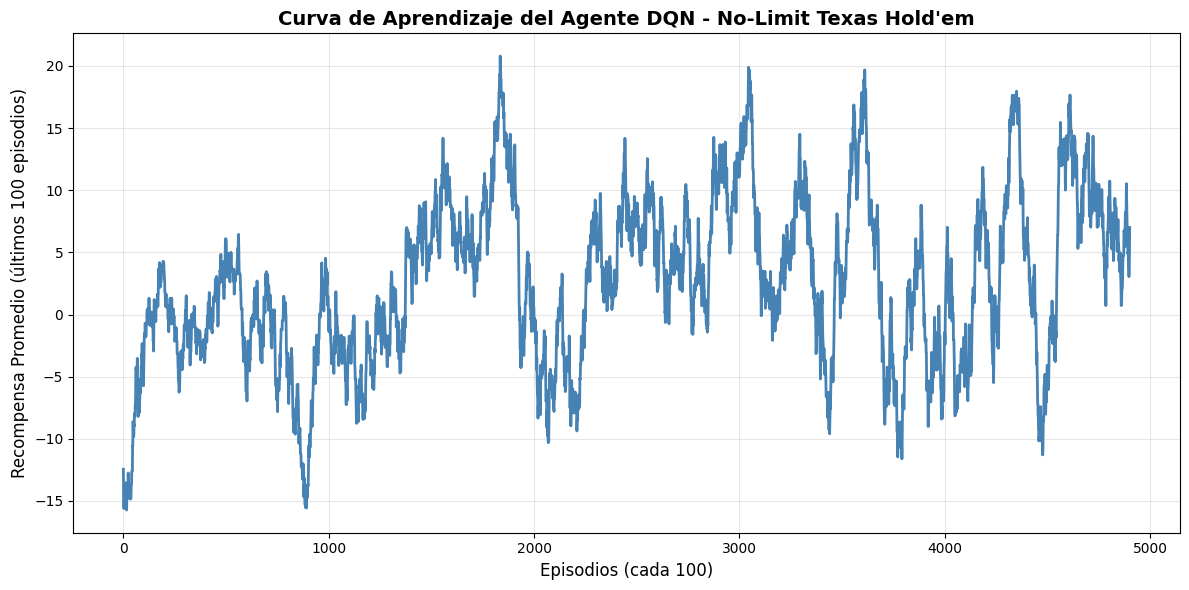

Win Rate Final: 73.60%


In [ ]:
if __name__ == "__main__":
    print("\n" + "🃏"*30)
    print("AGENTE DQN PARA NO-LIMIT TEXAS HOLD'EM POKER")
    print("🃏"*30 + "\n")

    # Se entrena el agente
    trained_agent, rewards = train_agent(num_episodes=5000, eval_every=1000)

    # Evaluación final
    final_win_rate = final_evaluation(trained_agent, num_games=1000)

    # Se visualiza el progreso
    plot_training_progress(rewards)

    print(f"Win Rate Final: {final_win_rate:.2%}")

Se observa que el agente ha aprendido a jugar contra oponentes aleatorios.

Para mejorar aún más se considera:

* Entrenar por más episodios.
* Jugar contra oponentes más fuertes.
* Ajustar mejor los hiperparámetros (learning rate, gamma, epsilon decay).
* Implementar variantes como Double DQN o Dueling DQN.

# Usando el modelo

En las siguientes celdas se añaden las funciones `play_games`, `play_demo_game` para ver al agente en acción paso a paso e imprimir estadísticas detalladas de aganancias/pérdidas (Payoff) y acciones específicas como Fold, Raise, etc., en una partida de ejemplo.

In [ ]:
def play_games(agent, num_games=100, verbose=True):
    """
    Jugar partidas de poker usando el agente entrenado.

    Args:
        agent (DQNAgent): Agente entrenado
        num_games (int): Número de partidas a jugar
        verbose (bool): Si es True, muestra información detallada

    Retorna:
        dict: Estadísticas de las partidas jugadas
    """
    # Se crear el entorno
    env = rlcard.make('no-limit-holdem')

    # Se configura el agente contra oponentes aleatorios
    env.set_agents([agent] + [RandomAgent(num_actions=num_actions)
                              for _ in range(env.num_players - 1)])

    # Variables para estadísticas
    wins = 0
    losses = 0
    total_payoff = 0
    payoffs = []

    print(f"\n🎮 Jugando {num_games} partidas...\n")

    # Se juegan las partidas
    for game in range(num_games):
        # Se ejecuta una partida completa
        trajectories, game_payoffs = env.run(is_training=False)

        # Se obtiene el resultado del agente (jugador 0)
        payoff = game_payoffs[0]
        total_payoff += payoff
        payoffs.append(payoff)

        # Se cuentan las victorias/derrotas
        if payoff > 0:
            wins += 1
        elif payoff < 0:
            losses += 1

        # Se muestra progreso
        if verbose and (game + 1) % 20 == 0:
            current_wr = wins / (game + 1)
            avg_payoff = total_payoff / (game + 1)
            print(f"Partida {game + 1}/{num_games} | "
                  f"Win Rate: {current_wr:.2%} | "
                  f"Payoff Promedio: {avg_payoff:+.3f}")

    # Se calculan las estadísticas finales
    win_rate = wins / num_games
    loss_rate = losses / num_games
    tie_rate = (num_games - wins - losses) / num_games
    avg_payoff = total_payoff / num_games
    std_payoff = np.std(payoffs)

    stats = {
        'win_rate': win_rate,
        'loss_rate': loss_rate,
        'tie_rate': tie_rate,
        'avg_payoff': avg_payoff,
        'std_payoff': std_payoff,
        'total_wins': wins,
        'total_losses': losses,
        'total_games': num_games
    }

    return stats

In [ ]:
def print_statistics(stats):
    """
    Se imprimen las estadísticas de las partidas jugadas.

    Args:
        stats (dict): Diccionario con las estadísticas
    """
    print("\n" + "="*60)
    print("ESTADÍSTICAS DE RENDIMIENTO")
    print("="*60)
    print(f"  Total de Partidas:      {stats['total_games']}")
    print(f"  Victorias:              {stats['total_wins']} ({stats['win_rate']:.2%})")
    print(f"  Derrotas:               {stats['total_losses']} ({stats['loss_rate']:.2%})")
    print(f"  Empates:                {stats['total_games'] - stats['total_wins'] - stats['total_losses']} ({stats['tie_rate']:.2%})")
    print(f"  Payoff Promedio:        {stats['avg_payoff']:+.4f}")
    print(f"  Desviación Estándar:    {stats['std_payoff']:.4f}")
    print("="*60 + "\n")

In [ ]:
def play_demo_game(agent):
    """
    Se juega una partida de demostración mostrando cada acción.

    Args:
        agent (DQNAgent): Agente entrenado
    """
    print("\n" + "🃏"*30)
    print("PARTIDA DE DEMOSTRACIÓN")
    print("🃏"*30 + "\n")

    # Se crea el entorno
    env = rlcard.make('no-limit-holdem')
    env.set_agents([agent] + [RandomAgent(num_actions=num_actions)
                              for _ in range(env.num_players - 1)])

    # Diccionario de nombres de acciones
    action_names = {
        0: "FOLD",
        1: "CHECK/CALL",
        2: "RAISE (pequeño)",
        3: "RAISE (medio)",
        4: "RAISE (grande)",
        5: "ALL-IN"
    }

    # Se juega la partida
    trajectories, payoffs = env.run(is_training=False)

    # Se analiza la trayectoria del agente
    trajectory = trajectories[0]
    print(f"Acciones del agente DQN:")

    step = 1
    for i in range(0, len(trajectory), 2):
        if isinstance(trajectory[i], dict):
            state = trajectory[i]
            if i + 1 < len(trajectory):
                action = trajectory[i + 1]
                action_name = action_names.get(action, f"ACCIÓN {action}")
                print(f"  Paso {step}: {action_name}")
                step += 1

    # Se muestra el resultado
    payoff = payoffs[0]
    if payoff > 0:
        print(f"\nVICTORIA - Ganancia: +{payoff:.2f}")
    elif payoff < 0:
        print(f"\nDERROTA - Pérdida: {payoff:.2f}")
    else:
        print(f"\nEMPATE - Payoff: {payoff:.2f}")

    print()

In [ ]:
print("\n" + "="*60)
print("AGENTE DQN DE POKER - MODO INFERENCIA")
print("="*60 + "\n")

# Se juega una partida de demostración
play_demo_game(trained_agent)

# Se jeugan múltiples partidas y se evalúa el rendimiento
stats = play_games(trained_agent, num_games=1000, verbose=True)

# Se muestran las estadísticas
print_statistics(stats)


AGENTE DQN DE POKER - MODO INFERENCIA


🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏
PARTIDA DE DEMOSTRACIÓN
🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏🃏

Acciones del agente DQN:
  Paso 1: RAISE (medio)
  Paso 2: RAISE (medio)
  Paso 3: RAISE (medio)
  Paso 4: CHECK/CALL

DERROTA - Pérdida: -100.00


🎮 Jugando 1000 partidas...

Partida 20/1000 | Win Rate: 65.00% | Payoff Promedio: -12.100
Partida 40/1000 | Win Rate: 62.50% | Payoff Promedio: -13.275
Partida 60/1000 | Win Rate: 66.67% | Payoff Promedio: -11.067
Partida 80/1000 | Win Rate: 68.75% | Payoff Promedio: -6.088
Partida 100/1000 | Win Rate: 69.00% | Payoff Promedio: -6.930
Partida 120/1000 | Win Rate: 67.50% | Payoff Promedio: -8.092
Partida 140/1000 | Win Rate: 67.14% | Payoff Promedio: -6.121
Partida 160/1000 | Win Rate: 66.88% | Payoff Promedio: -4.550
Partida 180/1000 | Win Rate: 67.78% | Payoff Promedio: -4.267
Partida 200/1000 | Win Rate: 68.00% | Payoff Promedio: -4.550
Partida 220/1000 | Win Rate: 68.18% | Payoff Promedio: -4.941
Partida 240/100

## Referencias

Brown, N., Sandholm, T. (2019). *Superhuman AI for multiplayer poker. Science.* [https://doi.org/10.1126/science.aay2400](https://doi.org/10.1126/science.aay2400)

Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., … Hassabis, D. (2015). *Human-level control through deep reinforcement learning. Nature, 518*(7540), 529–533. [https://doi.org/10.1038/nature14236](https://doi.org/10.1038/nature14236)

Moravčík, M., Schmid, M., Burch, N., Lisý, V., Morrill, D., … Bowling, M. (2017). *DeepStack: Expert-level artificial intelligence in heads-up no-limit poker. Science, 356*(6337), 508-513. [https://doi.org/10.1126/science.aam6960](https://doi.org/10.1126/science.aam6960)

Zha, D., Lai, K.-H., Cao, Y., Huang, S., Wei, R., Guo, J., & Hu, X. (2019). *RLCard: A Toolkit for Reinforcement Learning in Card Games* [Preprint]. arXiv. [https://arxiv.org/abs/1910.04376](https://arxiv.org/abs/1910.04376)